In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Conv1D

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
df_distinct_stacks['listStackTrace'] = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.split('\n'))
corpus = df_distinct_stacks['listStackTrace'].tolist()
frames = pd.Series(list(set([elt for l in corpus for elt in l])))
df_frames = pd.DataFrame()
df_frames['frame'] = pd.get_dummies(frames).T.reset_index().rename(columns={'index': 'frame'})['frame']
df_frames['embedding'] = pd.get_dummies(frames).T.reset_index().apply(lambda x : x[1:].values, axis = 1)
df_distinct_stacks['rankFrames'] = df_distinct_stacks['listStackTrace'].apply(lambda x : index_frame(x, df_frames))

In [7]:
df_trace_sim = pd.DataFrame()
df_trace_sim['TraceSim'] = df_measures['TraceSim']
df_trace_sim['stack1'] = df_trace_sim.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[0], axis = 1)
df_trace_sim['stack2'] = df_trace_sim.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[1], axis = 1)

In [8]:
embeddings = 1 * np.random.randn(df_frames.shape[0] + 1, df_frames['embedding'][0].shape[0])
embeddings[0] = 0
embeddings[1:] = np.vstack(df_frames['embedding'].tolist())
embeddings.shape

(2251, 2250)

In [9]:
X = df_trace_sim[['stack1','stack2']]
Y = df_trace_sim['TraceSim']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.2)

max_length = df_distinct_stacks['listStackTrace'].apply(lambda x : len(x)).max()
X_train = padding(X_train, max_length)
X_validation = padding(X_validation, max_length)

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

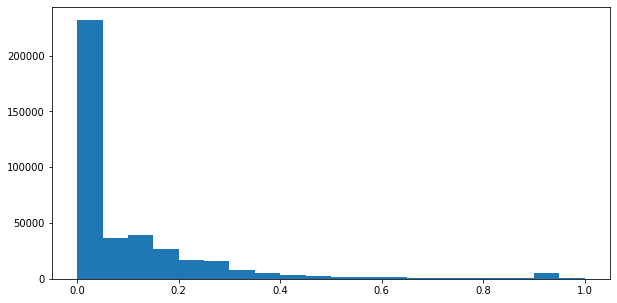

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

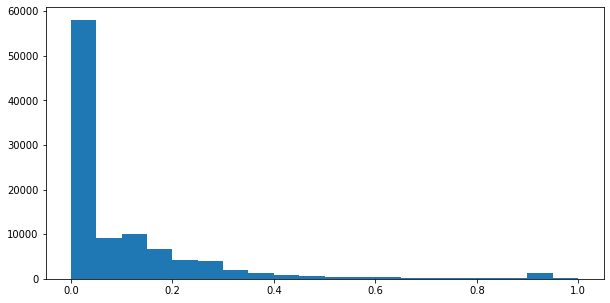

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
input_tensor = Input(shape = (max_length,))
input_layer = (Embedding(len(embeddings), df_frames.shape[0], weights=[embeddings], input_shape=(max_length,), trainable=False))(input_tensor)
submodels = []
for kw in (3,4) :
    conv_layer = Conv1D(1024, kw, activation='tanh')(input_layer)
    maxpool_layer = GlobalMaxPooling1D()(conv_layer)
    submodels.append(maxpool_layer)
conc_layer = concatenate(submodels, axis=1)
dense_layer = Dense(size_hash_vector, activation = 'tanh')(conc_layer)
x = Sequential()
x.add(Model(inputs = input_tensor, outputs = dense_layer))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (max_length,)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = False, print_summary = True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 29)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 29)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23292974    input_2[0][0]                    
                                                                 input_3[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_3[0][0]              

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 300s 377ms/step - loss: -0.4697 - manh_dist_loss: 0.0470 - abs_vect_loss: -0.9863 - abs_vect_1_loss: -0.9864 - manh_dist_rmse: 0.2167 - manh_dist_mae: 0.1577 - val_loss: -0.4813 - val_manh_dist_loss: 0.0268 - val_abs_vect_loss: -0.9892 - val_abs_vect_1_loss: -0.9895 - val_manh_dist_rmse: 0.1636 - val_manh_dist_mae: 0.1251
Epoch 2/20
781/781 [==============================] - 294s 377ms/step - loss: -0.4826 - manh_dist_loss: 0.0249 - abs_vect_loss: -0.9898 - abs_vect_1_loss: -0.9902 - manh_dist_rmse: 0.1578 - manh_dist_mae: 0.1206 - val_loss: -0.4834 - val_manh_dist_loss: 0.0238 - val_abs_vect_loss: -0.9903 - val_abs_vect_1_loss: -0.9909 - val_manh_dist_rmse: 0.1542 - val_manh_dist_mae: 0.1173
Epoch 3/20
781/781 [==============================] - 295s 377ms/step - loss: -0.4838 - manh_dist_loss: 0.0232 - abs_vect_loss: -0.9904 - abs_vect_1_loss: -0.9911 - manh_dist_rmse: 0.1524 - manh_dist_mae: 0.1161 - val_loss: -0.4842 - val_manh_d

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Baseline}$

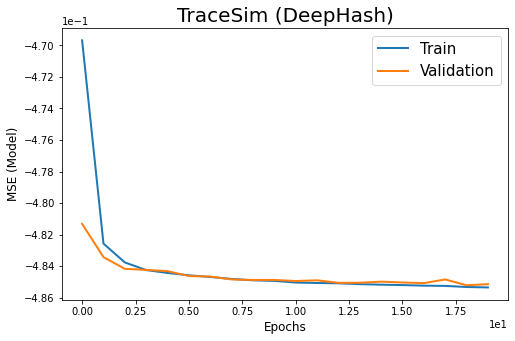

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('TraceSim (Baseline)', fontsize = 20)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of Hash preserving loss

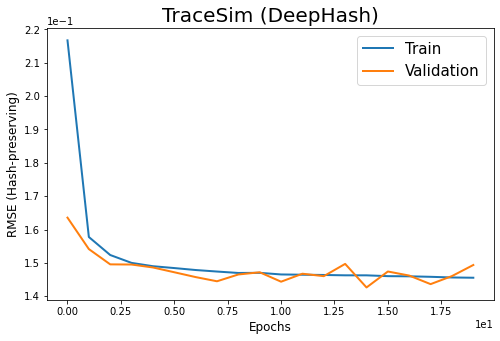

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('TraceSim (Baseline)', fontsize = 20)
plt.ylabel('RMSE (Hash-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of Hash preserving loss

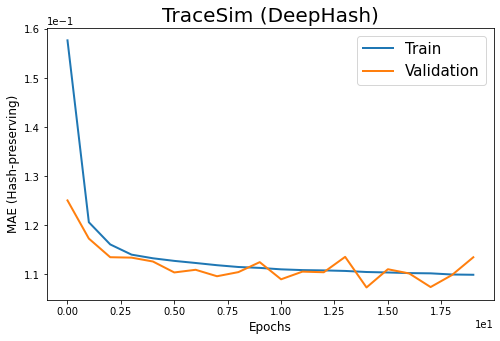

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('TraceSim (Baseline)', fontsize = 20)
plt.ylabel('MAE (Hash-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.076, 0.17 , 0.23 , 0.028, 0.341, 0.297, 0.059, 0.011, 0.219,
       0.234, 0.085, 0.145, 0.173, 0.015, 0.009, 0.009, 0.135, 0.075,
       0.186, 0.209, 0.083, 0.148, 0.088, 0.247, 0.254, 0.415, 0.232,
       0.021, 0.181, 0.321, 0.303, 0.201, 0.704, 0.185, 0.311, 0.011,
       0.286, 0.056, 0.636, 0.163, 0.424, 0.009, 0.349, 0.033, 0.765,
       0.133, 0.249, 0.266, 0.28 , 0.058], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.   , 0.102, 0.   , 0.17 , 0.138, 0.071, 0.   , 0.   ,
       0.174, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.129, 0.   , 0.   , 0.   , 0.   , 0.   , 0.238, 0.136,
       0.   , 0.   , 0.16 , 0.238, 0.078, 0.728, 0.   , 0.214, 0.   ,
       0.139, 0.   , 0.   , 0.122, 0.337, 0.   , 0.216, 0.   , 0.796,
       0.   , 0.   , 0.   , 0.139, 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

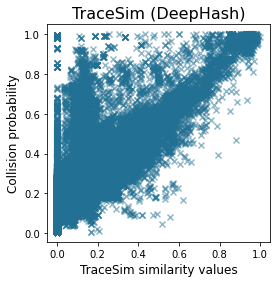

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('TraceSim (Baseline)', fontsize = 16)
plt.xlabel("TraceSim similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/TraceSim-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.7092221338110147

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.5300857145177773

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 0
model.layers[output_layer]

In [32]:
intermediate_model = intermediate_model_trained(shared_model, output_layer, True, input_tensor)

In [33]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-deep-hash.model/assets


In [ ]:
#intermediate_model = keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
intermediate_model.predict(padding(X.iloc[[11]], max_length)['stack_1'])[0][:32]

array([ 0.9950812 ,  0.86956763,  0.83945596,  0.77933484, -0.8825619 ,
       -0.6562294 , -0.9990957 ,  0.73356205,  0.76517576, -0.98847246,
       -0.70872694, -0.999598  ,  0.59227914, -0.7113451 , -0.7277603 ,
        0.8266487 ,  0.71804756, -0.59059304,  0.69524395, -0.74045384,
       -0.83101016, -0.7367871 ,  0.7938937 ,  0.87203896, -0.73646516,
        0.61149293,  0.8404781 ,  0.7267781 ,  0.7904629 , -0.8548718 ,
        0.8423648 ,  0.9129315 ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(pad_sequences(df_distinct_stacks['rankFrames'], padding = 'post', truncating = 'post', maxlen = 29)) 

In [36]:
np.mean(np.abs(hash_vectors))

0.69208306

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [37]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.0004814453125

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

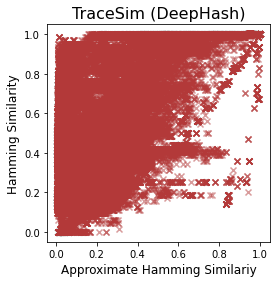

In [39]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('TraceSim (Baseline)', fontsize = 16)
plt.savefig('Results/Baseline/TraceSim-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [40]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [41]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


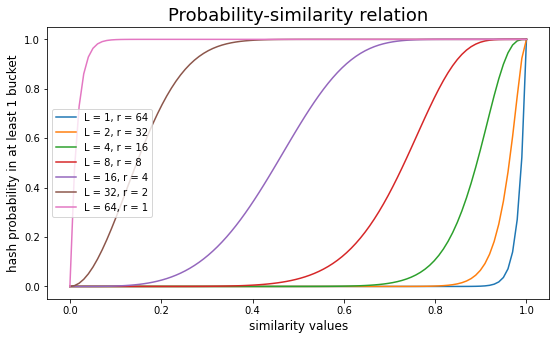

In [42]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [43]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'TraceSim', trace = False)

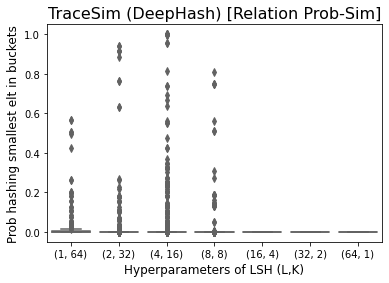

In [44]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('TraceSim (Baseline) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/Baseline/TraceSim-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [48]:
'Exemple, L = K = 8'
L, K = params[2]
L, K

(4, 16)

In [49]:
df_probLSH.mean()['(4, 16)']

0.03452860368723873

In [50]:
df_probLSH.median()['(4, 16)']

0.0

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [51]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [52]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [ ]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

In [ ]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

In [ ]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [ ]:
near_duplicates_sim = df_measures['TraceSim'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

In [ ]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'TraceSim', n_stacks, n_duplicate_pairs)
set_real_nns

In [ ]:
real_nns_sim[:n_duplicate_pairs]

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [45]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'TraceSim')

0.81

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'TraceSim')

-----------------------------------------------------------------

In [46]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'TraceSim')

0.7763333333333325

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'TraceSim')

-----------------------------------------------------------------

In [47]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'TraceSim')

0.757000000000001

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'TraceSim')

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [ ]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

In [53]:
df_knns = mean_generalized_mrr(n_stacks, params[2:4], hash_vectors_hamming, b, df_measures ,'TraceSim', trace = True)
df_knns.mean(skipna = True, axis = 0)

(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(4, 16)    0.596517
(8, 8)     0.561301
dtype: float64